In [1]:
%%capture
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import pickle
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

In [2]:
%%capture
from nilearn.datasets import fetch_abide_pcp

abide_data=fetch_abide_pcp(
                               pipeline="cpac",
                               derivatives=["rois_aal"],
                               band_pass_filtering=True,
                               data_dir="/home/comlab/Mahyar/Master_project_fMRI/AAL_atlas"
                               )


all_signals=[abide_data["rois_aal"][i][:,0:90] for i in range(len(abide_data["rois_aal"]))]

df_info=abide_data["phenotypic"][["SUB_ID","SITE_ID","DX_GROUP","AGE_AT_SCAN","SEX"]]
df_info.index=np.arange(len(df_info))
site_names=list(set(df_info["SITE_ID"]))

even_ind=np.arange(0,90,2)
odd_ind=np.arange(1,90,2)[::-1]
rearrange_arr=np.hstack((even_ind,odd_ind))

labels=np.array(pd.read_csv("/home/comlab/Mahyar/Master_project_fMRI/aal_labels.csv", skiprows=1).iloc[:,-1])[0:90]
labels=labels[rearrange_arr]

all_signals=[all_signals[i][:,rearrange_arr] for i in range(len(all_signals))]
num_rois=all_signals[0].shape[-1]
edge_ind=np.triu_indices(num_rois,k=1)

In [3]:
def MEM_estimator(binarized_signals, n_epochs=1000, eps=0.01):
    t_max=binarized_signals.shape[0]
    num_rois=binarized_signals.shape[-1]
    empirical_averages=binarized_signals.mean(axis=0)
    empirical_correlations=(binarized_signals.T@binarized_signals)/t_max
    J_error=[]
    h_error=[]
    #intial values
    #J=-np.linalg.inv(np.cov(binarized_signals.T))
    x=np.random.normal(0.3,1,size=int(num_rois*(num_rois-1)/2))
    edge_ind=np.triu_indices(num_rois,k=1)
    J=np.zeros((num_rois,num_rois))
    J[edge_ind]=x
    J=J+J.T
    h=np.random.normal(size=(num_rois))
    

    for i in range(n_epochs):

        model_averages=(np.tanh(np.tile(h, (t_max,1))+binarized_signals@J)).mean(axis=0)
        model_correlations=np.zeros((num_rois,num_rois))

        for t in range(t_max):
            model_correlations=model_correlations+binarized_signals[t,:].reshape(-1,1)@np.tanh(
                (h+J@binarized_signals[t,:]).reshape(1,-1)
            )

        model_correlations=model_correlations/t_max

        delta_h=empirical_averages-model_averages
        h=h+eps*delta_h
        delta_J=empirical_correlations-model_correlations
        J=J+eps*delta_J
        np.fill_diagonal(J,0)
        np.fill_diagonal(delta_J,0)
        J=(J+J.T)/2
        #J_error.append(np.abs(delta_J[edge_ind]).sum())
        #h_error.append(np.abs(delta_h).sum())

    
        
    return (h,J,np.abs(delta_h).sum()/num_rois,np.abs(delta_J[edge_ind]).sum()/len(edge_ind[0]))

In [4]:
#preprocessing and binarizing

#healthy_signals={}
#autistic_signals={}
binarized_signals=[]

for i,signal in enumerate(all_signals):
    mean_signal=signal.mean()
    signal=signal-mean_signal
    signal[signal<0]=-1
    signal[signal>0]=1

    binarized_signals.append(signal)

In [5]:
#categorizing four age ranges

age_ranges_dict={}
age_ranges_dict["young_child"]=[(6,9),[]]
age_ranges_dict["child"]=[(9,13),[]]
age_ranges_dict["teen"]=[(16,16.6),[]]
age_ranges_dict["young_adult"]=[(22,42),[]]
age_ranges_dict["middle_age"]=[(40,60),[]]

#site_list=["NYU","SDSU","UM_1","UM_2","USM","YALE"]

df_info_male=df_info[df_info["SEX"]==1]
#df_info_male=df_info_male[df_info_male["SITE_ID"].isin(site_list)]

for key in age_ranges_dict.keys():
    age_ranges_dict[key][1]=np.array(df_info_male[(df_info_male["AGE_AT_SCAN"]>
                                                   age_ranges_dict[key][0][0])&
                                                   (df_info_male["AGE_AT_SCAN"]<
                                                    age_ranges_dict[key][0][1])].index)
    


In [9]:
len(age_ranges_dict["middle_age"][-1])

13

In [5]:
#loading all models

with open("MEM_models_list_aal.pkl","rb") as file:
    models_list=pickle.load(file)

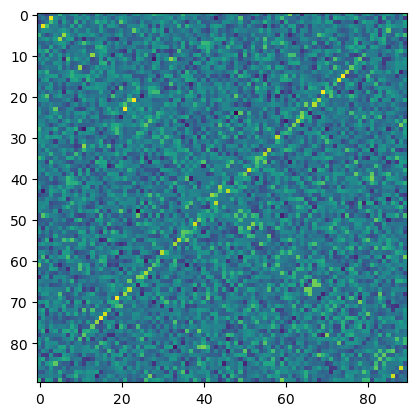

In [6]:
from nilearn.connectome import ConnectivityMeasure


connectome = ConnectivityMeasure(kind='partial correlation')
p_matrix=connectome.fit_transform([binarized_signals[0]])[0]
np.fill_diagonal(p_matrix,0)
plt.figure()
plt.imshow(p_matrix)



In [7]:
#now want to see if there is any difference between ising energies of two groups

def Ising_physical_results(J,h,signal):
    
    #T=1(beta=1)
    averages=signal.mean(axis=0)
    correlations=(signal.T@signal)/signal.shape[0]
    edge_ind=np.triu_indices(signal.shape[-1],k=1)

    averaged_energy=-2*np.sum(J[edge_ind]*correlations[edge_ind])-np.sum(averages*h)

    D=np.diag(1-averages**2)
    covariance_matrix=D@np.linalg.inv(np.identity(signal.shape[-1])-D@J)

    return averaged_energy,covariance_matrix

In [ ]:
# for teens, calculating suceptibility

dx_age_group_dict=age_ranges_dict.copy()

for key in dx_age_group_dict.keys():
    age_index=age_ranges_dict[key][-1]
    dx_age_group_dict[key]={}
    dx_age_group_dict[key]["healthy"]=[]
    dx_age_group_dict[key]["autism"]=[]
  

    for i in age_index:

        if df_info["DX_GROUP"][i]==1:

            sol=Ising_physical_results(models_list[i][1],models_list[i][0],binarized_signals[i])[1]
            dx_age_group_dict[key]["healthy"].append(sol)
            
        else:
            sol=Ising_physical_results(models_list[i][1],models_list[i][0],binarized_signals[i])[1]
            dx_age_group_dict[key]["autism"].append(sol)
            

In [24]:
pd.Series((dx_age_group_dict["teen"]["autism"][0]-dx_age_group_dict["teen"]["healthy"][0])[edge_ind]).describe()

count    4005.000000
mean       -0.001088
std         0.184721
min        -0.781860
25%        -0.112904
50%        -0.004083
75%         0.111409
max         0.907072
dtype: float64

In [55]:
%%capture
#for male teens of age between [16,16.6]

autism_dict={"binary_data":[],"J":[],"h":[]}
healthy_dict={"binary_data":[],"J":[],"h":[]}

for i in age_ranges_dict["young_adult"][-1]:
    if df_info["DX_GROUP"][i]==1:
        healthy_dict["J"].append(models_list[i][1])
        healthy_dict["h"].append(models_list[i][0])
        healthy_dict["binary_data"].append(binarized_signals[i])

    else:
        autism_dict["J"].append(models_list[i][1])
        autism_dict["h"].append(models_list[i][0])
        autism_dict["binary_data"].append(binarized_signals[i])    


healthy_dict["binary_data"].pop()
healthy_dict["J"].pop()
healthy_dict["h"].pop() 

for i in range(10):
    autism_dict["binary_data"].pop()
    autism_dict["J"].pop()
    autism_dict["h"].pop() 
    

In [87]:
print(len(healthy_dict["J"]))
print(len(autism_dict["J"]))

10
10


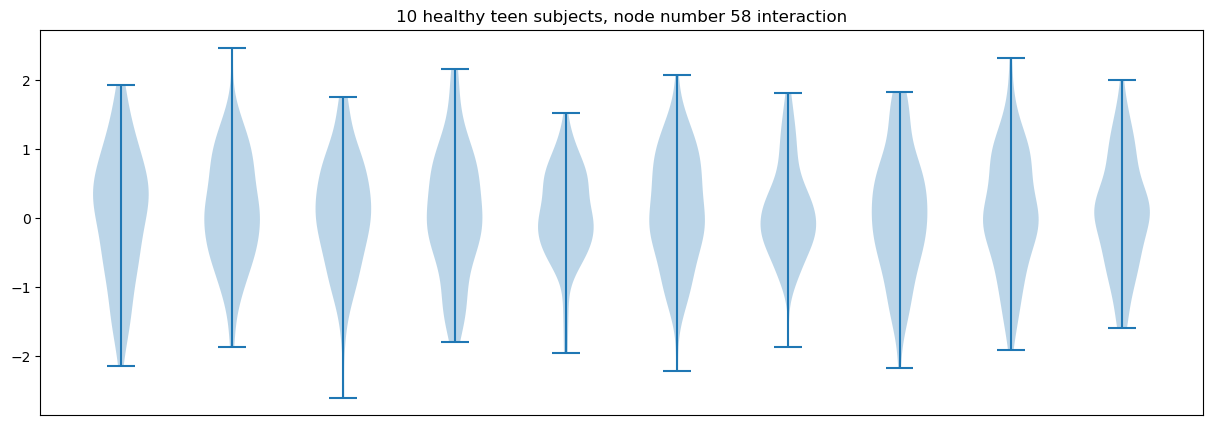

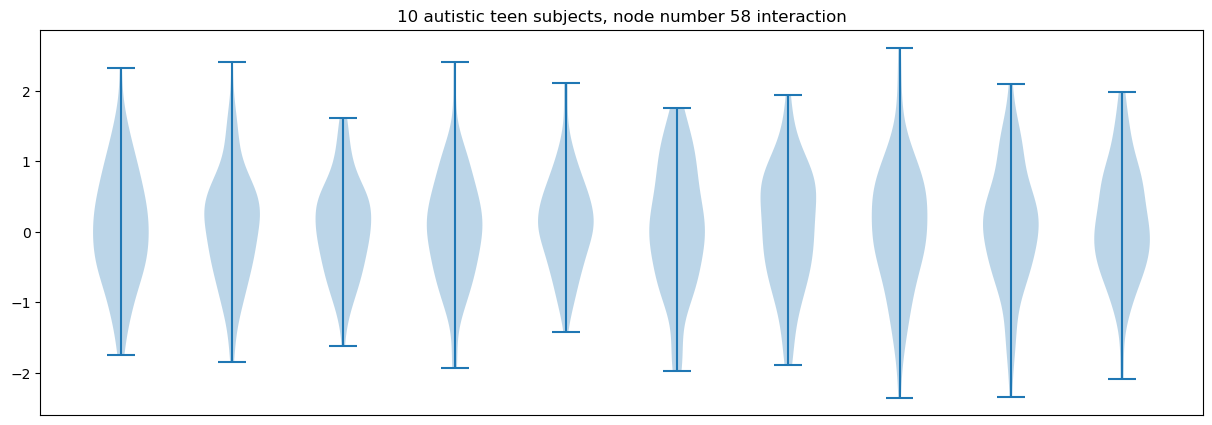

In [58]:
#plotting violinplot
node=np.argmax(models_list[0][1].sum(axis=0))+10

plt.figure(figsize=(15,5))

data_violin_hea=[]
data_violin_aut=[]
for i in range(10):
    data_violin_hea.append(healthy_dict["J"][i][:,node])
    data_violin_aut.append(autism_dict["J"][i][:,node])

plt.violinplot(data_violin_hea)
plt.title(f"10 healthy teen subjects, node number {node} interaction")
plt.xticks([])
plt.show()    

plt.figure(figsize=(15,5))
plt.violinplot(data_violin_aut)
plt.title(f"10 autistic teen subjects, node number {node} interaction")
plt.xticks([])
plt.show()    

In [59]:
#avg_J
J_hea=np.array(healthy_dict["J"]).mean(axis=0)
h_hea=np.array(healthy_dict["h"]).mean(axis=0)

J_aut=np.array(autism_dict["J"]).mean(axis=0)
h_aut=np.array(autism_dict["h"]).mean(axis=0)

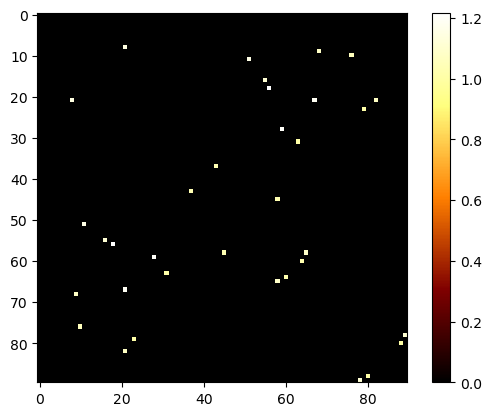

In [83]:
plt.figure()
m=np.abs(J_hea-J_aut)
m[m<1]=0
ax=plt.imshow(m,cmap="afmhot")
plt.colorbar(ax)

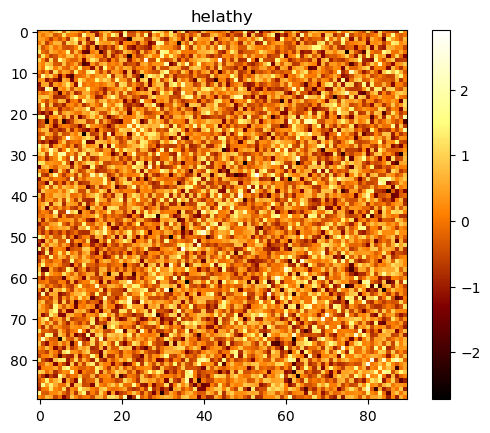

In [86]:
plt.figure()
ax=plt.imshow(autism_dict["J"][1],cmap="afmhot")
plt.colorbar(ax)
plt.title("helathy")
plt.show()

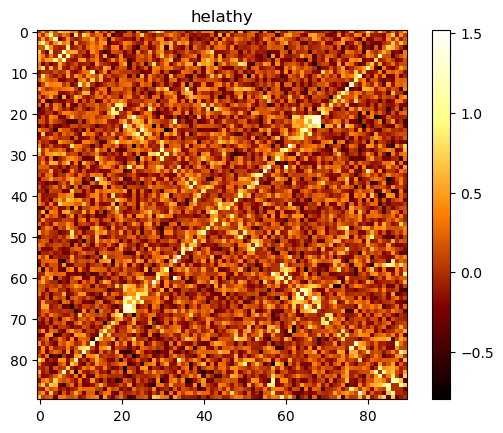

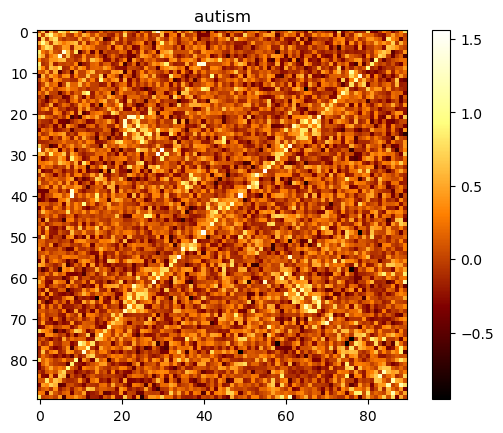

In [80]:
plt.figure()
ax=plt.imshow(J_hea,cmap="afmhot")
plt.colorbar(ax)
plt.title("helathy")
plt.show()

plt.figure()
ax=plt.imshow(J_aut,cmap="afmhot")
plt.colorbar(ax)
plt.title("autism")
plt.show()


In [72]:
(np.array(healthy_dict["J"]).std(axis=0)/np.sqrt(10)).max()

0.42320214705860093

<Axes: ylabel='Count'>

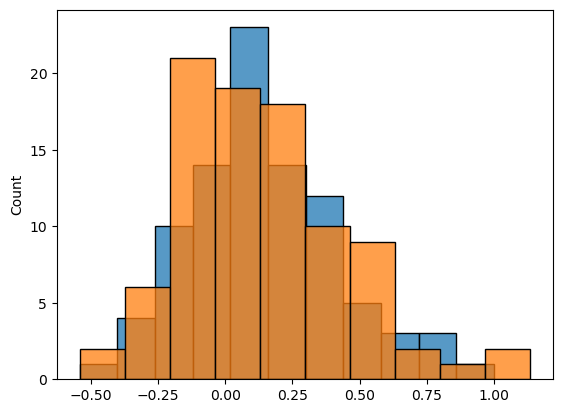

In [79]:
sb.histplot(J_aut[:,80])
sb.histplot(J_hea[:,80])

In [27]:
l1=np.sort(np.linalg.eigvals(np.diag(dx_age_group_dict["teen"]["healthy"][0].sum(axis=0))-dx_age_group_dict["teen"]["healthy"][0]))

In [30]:
l2=np.sort(np.linalg.eigvals(np.diag(dx_age_group_dict["teen"]["healthy"][1].sum(axis=0))-dx_age_group_dict["teen"]["healthy"][1]))

In [115]:
### for adults
averaged_cov_dict=dx_age_group_dict.copy()
for key in averaged_cov_dict.keys():

    averaged_cov_dict[key]["healthy"]=[np.array(dx_age_group_dict[key]["healthy"]).mean(axis=0),
                                             np.array(dx_age_group_dict[key]["healthy"]).std(axis=0)/np.sqrt(len(dx_age_group_dict[key]["healthy"])-1)]
    averaged_cov_dict[key]["autism"]=[np.array(dx_age_group_dict[key]["autism"]).mean(axis=0),
                                             np.array(dx_age_group_dict[key]["autism"]).std(axis=0)/np.sqrt(len(dx_age_group_dict[key]["autism"])-1)]

In [78]:
adult_age_index=age_ranges_dict["young_adult"][-1]

J_dict={"autism":[],"healthy":[]}
h_dict={"autism":[],"healthy":[]}
avg_J_dict=J_dict.copy()
avg_h_dict=h_dict.copy()

for i in adult_age_index:


    if df_info["DX_GROUP"][i]==1:

        J_dict["healthy"].append(models_list[i][1])
        h_dict["healthy"].append(models_list[i][0])    
    else:
        J_dict["autism"].append(models_list[i][1])
        h_dict["autism"].append(models_list[i][0])

avg_J_dict["healthy"]=[np.array(J_dict["healthy"]).mean(axis=0),
                                             np.array(J_dict["healthy"]).std(axis=0)/np.sqrt(len(J_dict["healthy"])-1)]
avg_J_dict["autism"]=[np.array(J_dict["autism"]).mean(axis=0),
                                             np.array(J_dict["autism"]).std(axis=0)/np.sqrt(len(J_dict["autism"])-1)] 

avg_h_dict["healthy"]=[np.array(h_dict["healthy"]).mean(axis=0),
                                             np.array(h_dict["healthy"]).std(axis=0)/np.sqrt(len(h_dict["healthy"])-1)]
avg_h_dict["autism"]=[np.array(h_dict["autism"]).mean(axis=0),
                                             np.array(h_dict["autism"]).std(axis=0)/np.sqrt(len(h_dict["autism"])-1)]       

<Axes: ylabel='Count'>

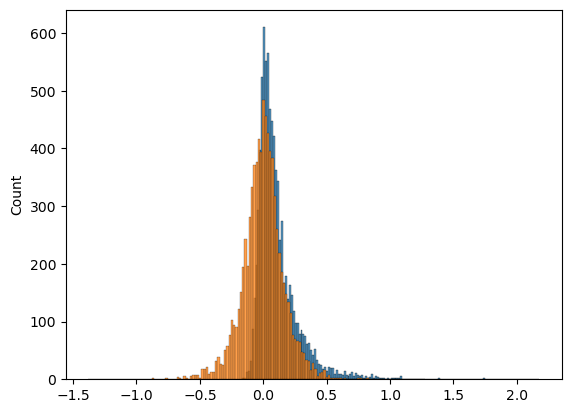

In [100]:
sb.histplot(averaged_cov_dict["young_adult"]["healthy"][0].flatten())
sb.histplot(averaged_cov_dict["young_adult"]["autism"][0].flatten())

In [ ]:
#now I wanna imshow plot C and J

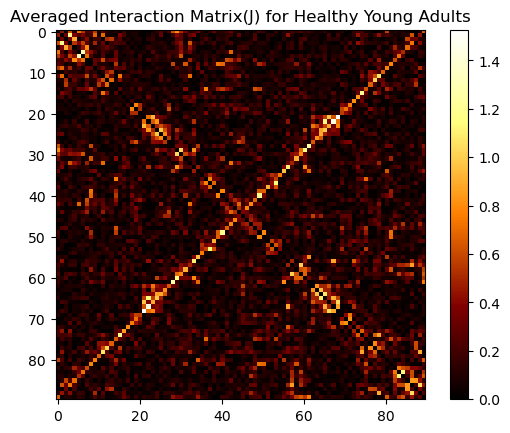

In [136]:
plt.figure()
ax=plt.imshow(np.abs(avg_J_dict["healthy"][0]),cmap="afmhot")
plt.colorbar(ax)
plt.title("Averaged Interaction Matrix(J) for Healthy Young Adults")
plt.show()

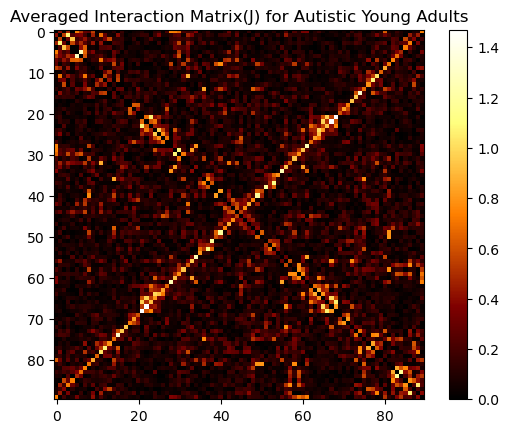

In [135]:
plt.figure()
ax=plt.imshow(np.abs(avg_J_dict["autism"][0]),cmap="afmhot")
plt.colorbar(ax)
plt.title("Averaged Interaction Matrix(J) for Autistic Young Adults")
plt.show()

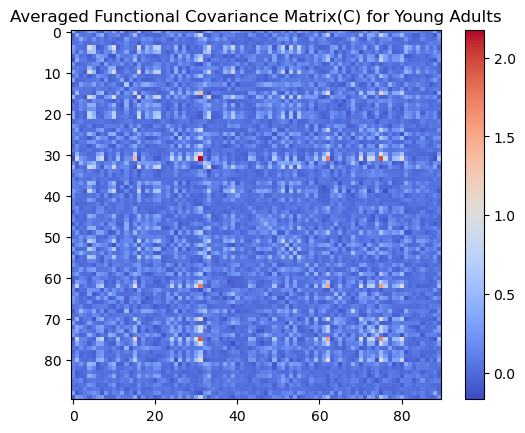

In [106]:
plt.figure()
ax=plt.imshow(averaged_cov_dict["young_adult"]["healthy"][0],cmap="coolwarm")
plt.colorbar(ax)
plt.title("Averaged Functional Covariance Matrix(C) for Young Adults")
plt.show()

In [129]:
key="teen"
chi_list_aut=[averaged_cov_dict[key]["autism"][0].sum(axis=0),np.sqrt(averaged_cov_dict[key]["autism"][1]**2).sum(axis=0)]
chi_list_hea=[averaged_cov_dict[key]["healthy"][0].sum(axis=0),np.sqrt(averaged_cov_dict[key]["healthy"][1]**2).sum(axis=0)]

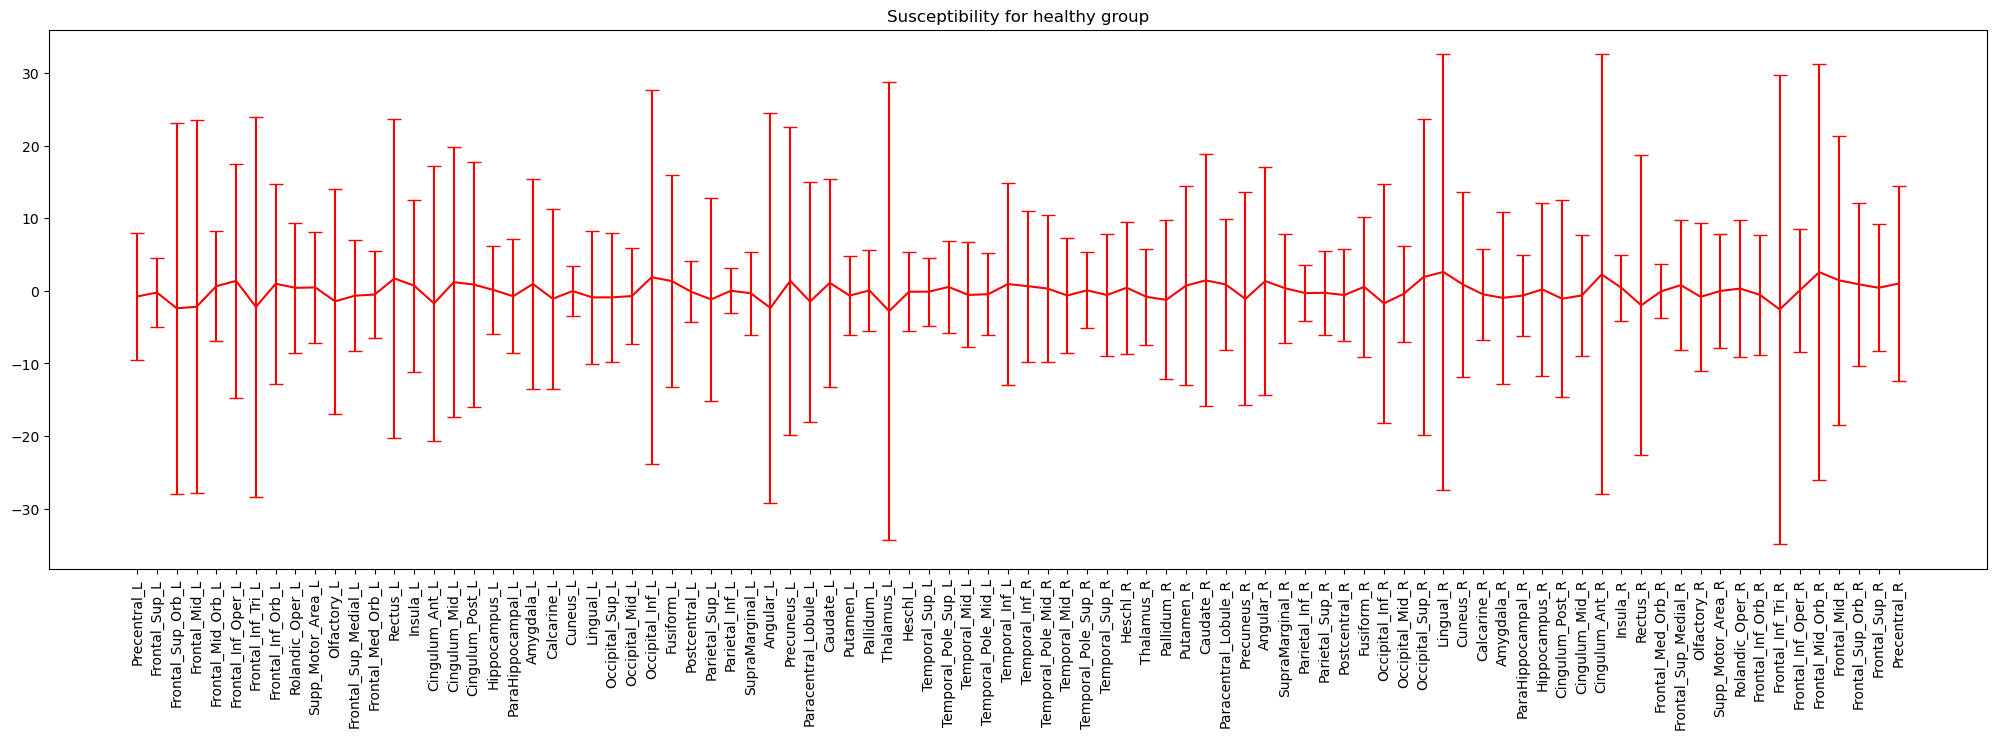

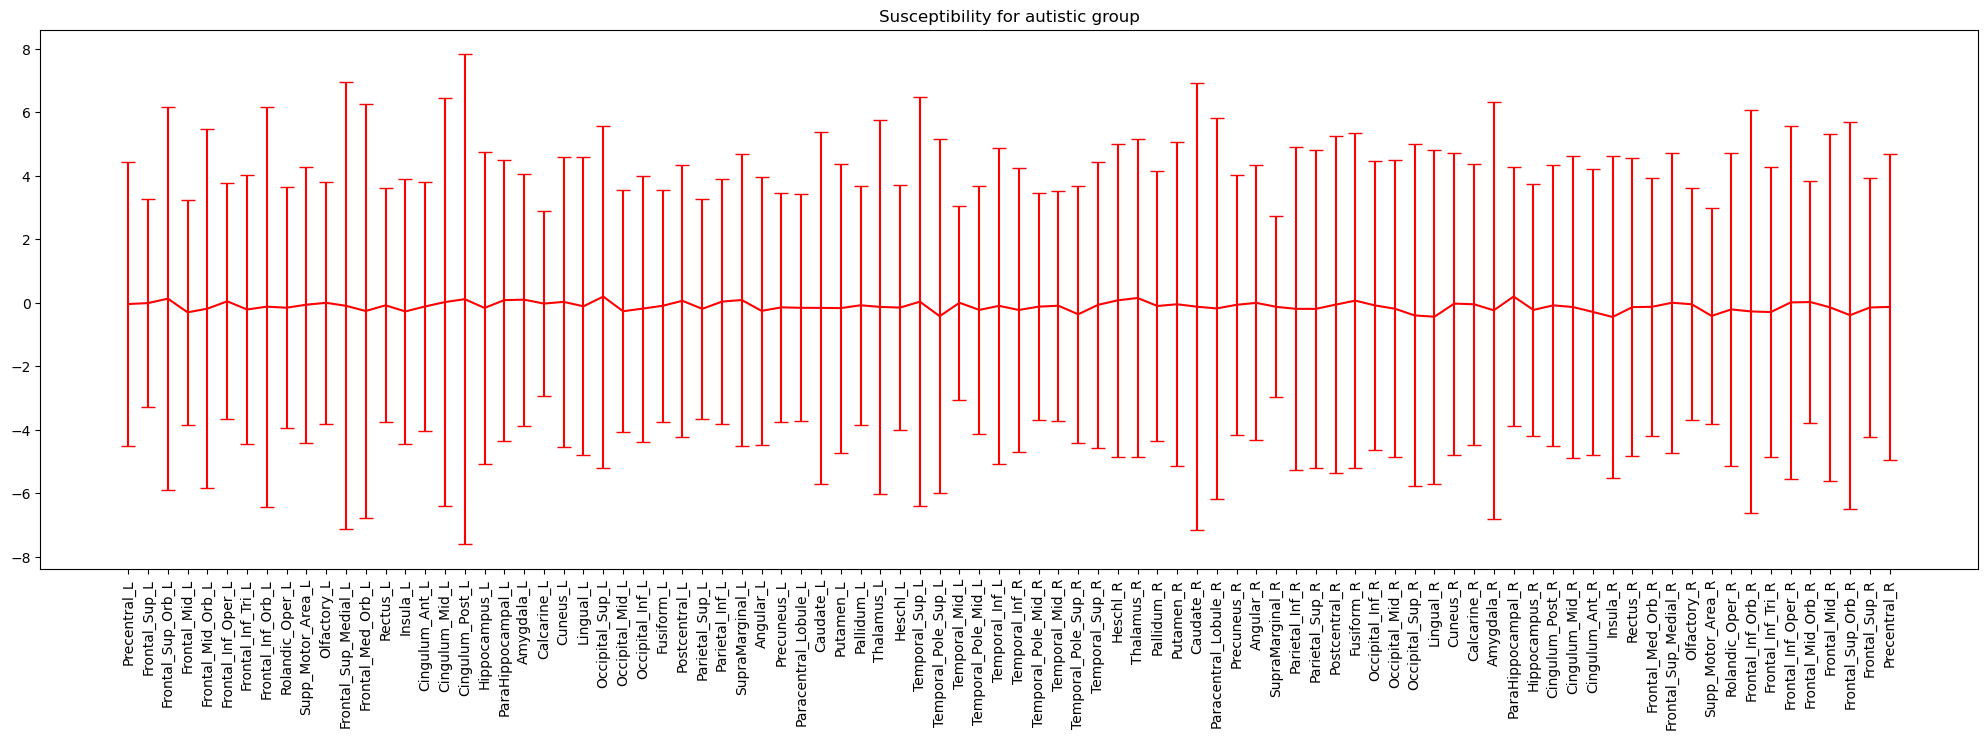

In [130]:
figsize=(25,7)
plt.figure(figsize=figsize)
plt.errorbar(np.arange(num_rois),chi_list_hea[0],yerr=chi_list_hea[1],capsize=5,c="r")
plt.xticks(np.arange(num_rois),labels,rotation=90)
plt.title("Susceptibility for healthy group")
plt.show()

plt.figure(figsize=figsize)
plt.errorbar(np.arange(num_rois),chi_list_aut[0],yerr=chi_list_aut[1],capsize=5,c="r")
plt.xticks(np.arange(num_rois),labels,rotation=90)
plt.title("Susceptibility for autistic group")
plt.show()



<Axes: ylabel='Count'>

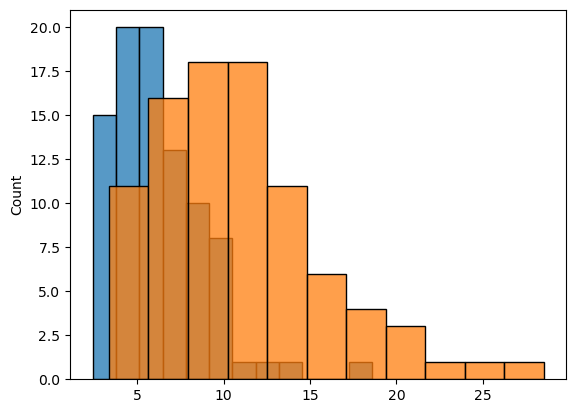

In [126]:
sb.histplot(chi_list_aut)
sb.histplot(chi_list_hea)

In [89]:
#now I want to save the data in a zip file

for i in range(10):
    np.savetxt(f"/home/comlab/Mahyar/Master_project_fMRI/abide_spinglass_files/healthy/{i}_signal_hea.txt",healthy_dict["binary_data"][i])
    np.savetxt(f"/home/comlab/Mahyar/Master_project_fMRI/abide_spinglass_files/healthy/{i}_J_hea.txt",healthy_dict["J"][i])
    np.savetxt(f"/home/comlab/Mahyar/Master_project_fMRI/abide_spinglass_files/healthy/{i}_h_hea.txt",healthy_dict["h"][i])

    np.savetxt(f"/home/comlab/Mahyar/Master_project_fMRI/abide_spinglass_files/autism/{i}_signal_aut.txt",autism_dict["binary_data"][i])
    np.savetxt(f"/home/comlab/Mahyar/Master_project_fMRI/abide_spinglass_files/autism/{i}_J_aut.txt",autism_dict["J"][i])
    np.savetxt(f"/home/comlab/Mahyar/Master_project_fMRI/abide_spinglass_files/autism/{i}_h_aut.txt",autism_dict["h"][i])
        
